In [177]:
using FileIO, RegisterQD, NRRD, ImageView, HDF5, MAT, Images,
    Unitful, AxisArrays, StaticArrays, CoordinateTransformations,
    ImageView, TestImages, NRRD, LinearAlgebra, ImageMagick,
    LibExpat, PyCall
using Unitful: μm, s

┌ Info: Precompiling PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1278


In [25]:
zbrain_dir = "O:\\users\\tyler\\zbrain\\AnatomyLabelDatabase.hdf5"
data_dir = "O:\\users\\tyler\\b113\\2020-08-04_elavl3-ChRmine-Kv2.1_elavl3-H2B-GCaMP6s\\fish2\\fov1_hab\\green-008\\"
zbrain_units = (0.798μm, 0.798μm, 2μm)

(0.798 μm, 0.798 μm, 2 μm)

### load zseries

In [175]:
# Bruker 2P
zseries = ImageMagick.load(joinpath(data_dir, "green-008_Cycle00001_Ch3_000001.ome.tif"));
zseries = reshape(zseries, size(zseries)..., 1);
zseries = reverse(zseries,dims=2);

### read microns per pixel (Bruker)

In [47]:
open(joinpath(data_dir, "green-008.xml"),"r") do io
    green_xml = read(io, String)
    global green_xml = xp_parse(green_xml)
end;

"apply each function to args"
funprod(functions...) = (args...)->map(x->x(args...), functions)

micronsPerPixel_xml = green_xml[xpath"""//PVStateValue[@key="micronsPerPixel"]"""][1]
# parse xml
lookup_μm = axis -> etree -> parse(Float64,
    micronsPerPixel_xml[xpath"""IndexedValue[@index="$axis"]"""][1].attr["value"])μm
microscope_units = funprod(map(lookup_μm, ["YAxis", "XAxis", "ZAxis"])...)(micronsPerPixel_xml)

In [176]:
imshow(zseries)

Dict{String,Any} with 4 entries:
  "gui"         => Dict{String,Any}("window"=>GtkWindowLeaf(name="", parent, wi…
  "roi"         => Dict{String,Any}("redraw"=>202: "map(clim-mapped image, inpu…
  "annotations" => 151: "input-53" = Dict{UInt64,Any}() Dict{UInt64,Any} 
  "clim"        => 150: "CLim" = CLim{Normed{UInt16,16}}(0.00011, 0.0099) CLim{…

In [20]:
size(zseries)

(1024, 1024)

### load reference

In [52]:
reference = load("$zbrain_dir/Ref20131120pt14pl2.nrrd")
reference = AxisArray(gray.(reference),
    (:y, :x, :z), zbrain_units)
W, H, Z = size(reference)

imshow(reference)

Dict{String,Any} with 4 entries:
  "gui"         => Dict{String,Any}("window"=>GtkWindowLeaf(name="", parent, wi…
  "roi"         => Dict{String,Any}("redraw"=>220: "map(clim-mapped image, inpu…
  "annotations" => 169: "input-60" = Dict{UInt64,Any}() Dict{UInt64,Any} 
  "clim"        => 168: "CLim" = CLim{RUInt16}(0x0000, 0x0271) CLim{RUInt16} 

### load zbrain h2b reference

In [53]:
h2b_zbrain = AxisArray(permutedims(
        h5read("$zbrain_dir/AnatomyLabelDatabase.hdf5", "Elavl3-H2BRFP_6dpf_MeanImageOf10Fish"),
        (2,1,3)),
    (:y, :x, :z), (0.798μm, 0.798μm, 2μm))
size(h2b_zbrain)

(621, 1406, 138)

In [9]:
imshow(h2b_zbrain)

Dict{String,Any} with 4 entries:
  "gui"         => Dict{String,Any}("window"=>GtkWindowLeaf(name="", parent, wi…
  "roi"         => Dict{String,Any}("redraw"=>165: "map(clim-mapped image, inpu…
  "annotations" => 114: "input-41" = Dict{UInt64,Any}() Dict{UInt64,Any} 
  "clim"        => 113: "CLim" = CLim{RUInt16}(0x0000, 0x2b9a) CLim{RUInt16} 

### load region masks

In [54]:
masks = matread("$zbrain_dir/MaskDatabase.mat")
keys(masks)

Base.KeySet for a Dict{String,Any} with 7 entries. Keys:
  "DateCreated"
  "MaskDatabaseNames"
  "height"
  "Zs"
  "MaskDatabase"
  "width"
  "MaskDatabaseOutlines"

In [55]:
size(example_mask)

(621, 1406, 138)

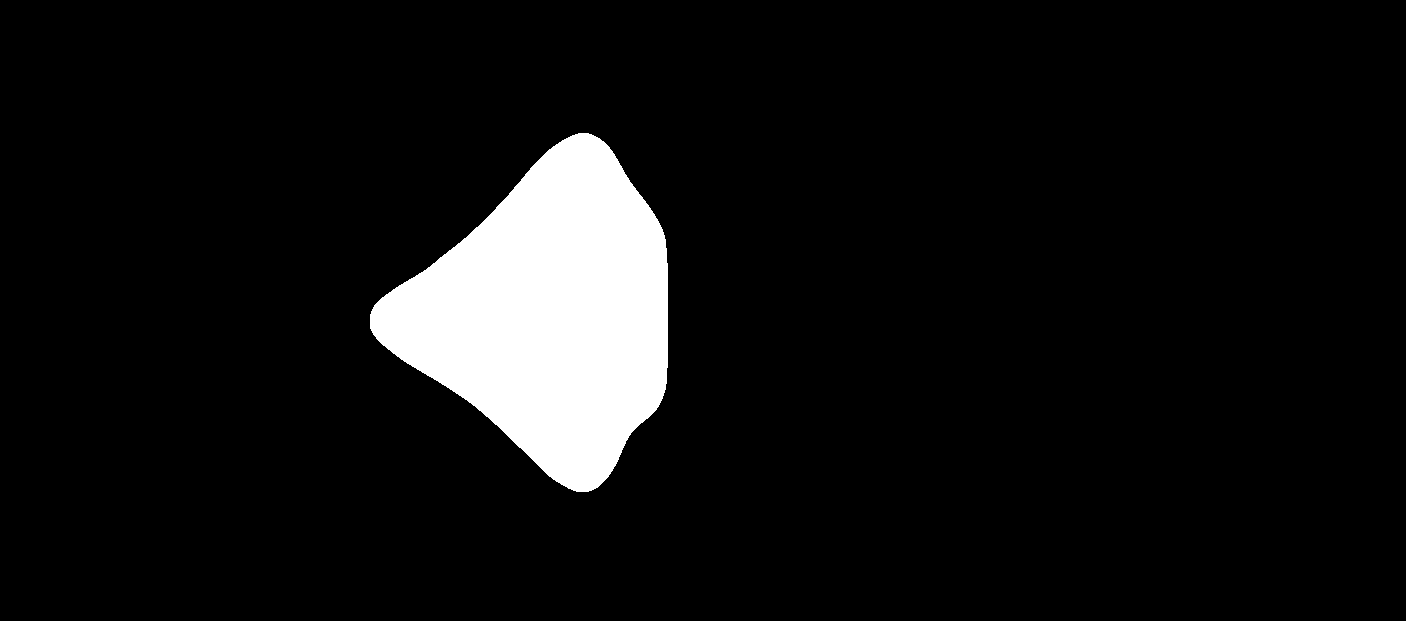

In [56]:
# reshape as [1406, 621, 138]
example_mask = reshape(Array(masks["MaskDatabase"][:,1]), (H, W, Z))
# reshape as [621, 1406, 138]
example_mask = permutedims(example_mask, (2,1,3))
example_mask = AxisArray(example_mask, (:y, :x, :z), zbrain_units)

# imshow(example_mask,axes=(2,3))
Gray.(example_mask[:,:,10])

### EXAMPLE TRANSLATION

In [63]:
h2 = copy(h2b_zbrain)
h2[:,10:end,:] = h2b_zbrain[:,1:end-9,:];

In [65]:
h2_translation_a = qd_translate(h2b_zbrain[:,:,100],
	h2[:,:,100], [10, 10]; maxevals=100)

# 291 sec
# h2_translation = qd_translate(h2b_zbrain,
# 	h2, [10, 10,10]; maxevals=100)

# h2_registered = warp(h2, h2_translation[1],
# 	Base.axes(h2b_zbrain));

@assert h2_translation_a[1].translation == [0., 9.]

Running coarse step
Running fine step
Initial minimum (5 evaluations): Box0.0@[0.0, NaN]
minimum (113 evaluations): Box0.0@[0.0, NaN]
Final minimum (113 evaluations): Box0.0@[0.0, NaN]
49 evaluations for initialization+sweeps, 64 for Quasi-Newton


In [ ]:
h2_translation = qd_translate(h2b_zbrain,
	h2, [10, 10,10]; maxevals=100)

h2_registered = warp(h2, h2_translation[1],
	Base.axes(h2b_zbrain));

### Example Affine

In [373]:
?qd_affine

search: qd_affine



`tform, mm = qd_affine(fixed, moving, mxshift, linmins, linmaxs, SD=I; presmoothed=false, thresh, initial_tfm, kwargs...)` `tform, mm = qd_affine(fixed, moving, mxshift, SD=I; presmoothed=false, thresh, initial_tfm, kwargs...)` optimizes an affine transformation (linear map + translation) to minimize the mismatch between `fixed` and `moving` using the QuadDIRECT algorithm.  The algorithm is run twice: the first step samples the search space at a coarser resolution than the second.  `kwargs...` may contain any keyword argument that can be passed to `QuadDIRECT.analyze`. It's recommended that you pass your own stopping criteria when possible (i.e. `rtol`, `atol`, and/or `fvalue`).  If you provide `rtol` and/or `atol` they will apply only to the second (fine) step of the registration; the user may not adjust these criteria for the coarse step.

`tform` will be centered on the origin-of-coordinates, i.e. (0,0) for a 2D image.  Usually it is more natural to consider rotations around the center of the image.  If you would like `mxrot` and the returned rotation to act relative to the center of the image, then you must move the origin to the center of the image by calling `centered(img)` from the `ImageTransformations` package.  Call `centered` on both the fixed and moving image to generate the `fixed` and `moving` that you provide as arguments.  If you later want to apply the returned transform to an image you must remember to call `centered` on that image as well.  Alternatively you can re-encode the transformation in terms of a different origin by calling `recenter(tform, newctr)` where `newctr` is the displacement of the new center from the old center.

The `linmins` and `linmaxs` arguments set the minimum and maximum allowable values in the linear map matrix. They can be supplied as NxN matrices or flattened vectors.  If omitted then a modest default search space is chosen. `mxshift` sets the magnitude of the largest allowable translation in each dimension (It's a vector of length N). This default search-space allows for very little rotation. Alternatively, you can submit `dmax` or `ndmax` values as keyword functions, which will use diagonal or non-diagonal variation from the identity matrix to generate less modest `linmins` and `linmaxs` arguments for you.

Use `presmoothed=true` if you have called [`qsmooth`](@ref) on `fixed` before calling `qd_affine`. Do not smooth `moving`.

`kwargs...` can also include any other keyword argument that can be passed to `QuadDIRECT.analyze`. It's recommended that you pass your own stopping criteria when possible (i.e. `rtol`, `atol`, and/or `fvalue`).

If you have a good initial guess at the solution, pass it with the `initial_tfm` kwarg to jump-start the search.

Use `SD` if your axes are not uniformly sampled, for example `SD = diagm(voxelspacing)` where `voxelspacing` is a vector encoding the spacing along all axes of the image. `thresh` enforces a certain amount of sum-of-squared-intensity overlap between the two images; with non-zero `thresh`, it is not permissible to "align" the images by shifting one entirely out of the way of the other.


In [223]:
h2_affine_plane = qd_affine(h2b_zbrain[100,:,:],
	h2[100,:,:], [10, 10]; maxevals=100)

Running coarse step
Initial minimum (9 evaluations): Box-2.2028488751365424e-17@[1.0, NaN, NaN, NaN]
minimum (112 evaluations): Box-2.2028488751365424e-17@[1.0, NaN, NaN, NaN]
Final minimum (112 evaluations): Box-2.2028488751365424e-17@[1.0, NaN, NaN, NaN]
59 evaluations for initialization+sweeps, 53 for Quasi-Newton
Running fine step
Initial minimum (13 evaluations): Box0.0@[0.0, NaN, NaN, NaN, NaN, NaN]
minimum (122 evaluations): Box0.0@[0.0, NaN, NaN, NaN, NaN, NaN]
Final minimum (122 evaluations): Box0.0@[0.0, NaN, NaN, NaN, NaN, NaN]
69 evaluations for initialization+sweeps, 53 for Quasi-Newton


(AffineMap([1.0 0.0; 0.0 1.0], [0.0, 9.0]), 0.0)

## Register Zseries

In [330]:
imshow(zseries*100, axes=(2,3))

Dict{String,Any} with 4 entries:
  "gui"         => Dict{String,Any}("window"=>GtkWindowLeaf(name="", parent, wi…
  "roi"         => Dict{String,Any}("redraw"=>730: "map(clim-mapped image, inpu…
  "annotations" => 679: "input-234" = Dict{UInt64,Any}() Dict{UInt64,Any} 
  "clim"        => 678: "CLim" = CLim{Float32}(0.0, 0.688182) CLim{Float32} 

In [63]:
imshow(h2b_zbrain[100,:,:])

Dict{String,Any} with 4 entries:
  "gui"         => Dict{String,Any}("window"=>GtkWindowLeaf(name="", parent, wi…
  "roi"         => Dict{String,Any}("redraw"=>142: "map(clim-mapped image, inpu…
  "annotations" => 108: "input-40" = Dict{UInt64,Any}() Dict{UInt64,Any} 
  "clim"        => 107: "CLim" = CLim{RUInt16}(0x0000, 0xed04) CLim{RUInt16} 

In [101]:
zeroToOne(x) = (x.-minimum(x))/(minimum(x) + maximum(x))

zeroToOne (generic function with 1 method)

In [109]:
zseries_translation

(Translation(23.47175994132213, -159.48883786199957), 0.898747288134574)

In [103]:
zseries_translation = qd_translate(zeroToOne(h2b_zbrain[96,:,:]),
	zeroToOne(zseries[20,:,:]), [200,200];
    initial_tfm=Translation())

Running coarse step
Running fine step
Initial minimum (5 evaluations): Box0.9011778156197332@[0.0, NaN]
minimum (136 evaluations): Box0.898747288134574@[-0.5282400586778702, -0.48883786199957546]
Final minimum (136 evaluations): Box0.898747288134574@[-0.5282400586778702, -0.48883786199957546]
37 evaluations for initialization+sweeps, 99 for Quasi-Newton


(Translation(23.47175994132213, -159.48883786199957), 0.898747288134574)

In [104]:
zseries_registered = warp(zseries[20,:,:], zseries_translation[1],
	Base.axes(h2b_zbrain[96,:,:]));

im = RGB.(h2b_zbrain[96,:,:]/maximum(h2b_zbrain))
channelview(im)[2:3,:,:] .= 0
channelview(im)[2,:,:] .= zseries_registered/maximum(zseries_registered)
# channelview(im)[2,:,:] .= zseries[20,:,:]/maximum(zseries[20,:,:])
im[:,:]

### Zseries affine 2D

In [371]:
zbrain_x_units = h2b_zbrain[Axis{:x}][2] - h2b_zbrain[Axis{:x}][1]
zbrain_y_units = h2b_zbrain[Axis{:y}][2] - h2b_zbrain[Axis{:y}][1]
zbrain_z_units = h2b_zbrain[Axis{:z}][2] - h2b_zbrain[Axis{:z}][1]
x_units = zseries[Axis{:x}][2] - zseries[Axis{:x}][1]
y_units = zseries[Axis{:y}][2] - zseries[Axis{:y}][1]
z_units = zseries[Axis{:z}][2] - zseries[Axis{:z}][1]
x_scaling = x_units/zbrain_x_units
y_scaling = y_units/zbrain_y_units
z_scaling = z_units/zbrain_z_units
(zbrain_x_units, zbrain_y_units, zbrain_z_units), (z_units, y_units, x_units)

((0.798 μm, 0.798 μm, 2 μm), (1 μm, 1 μm, 1 μm))

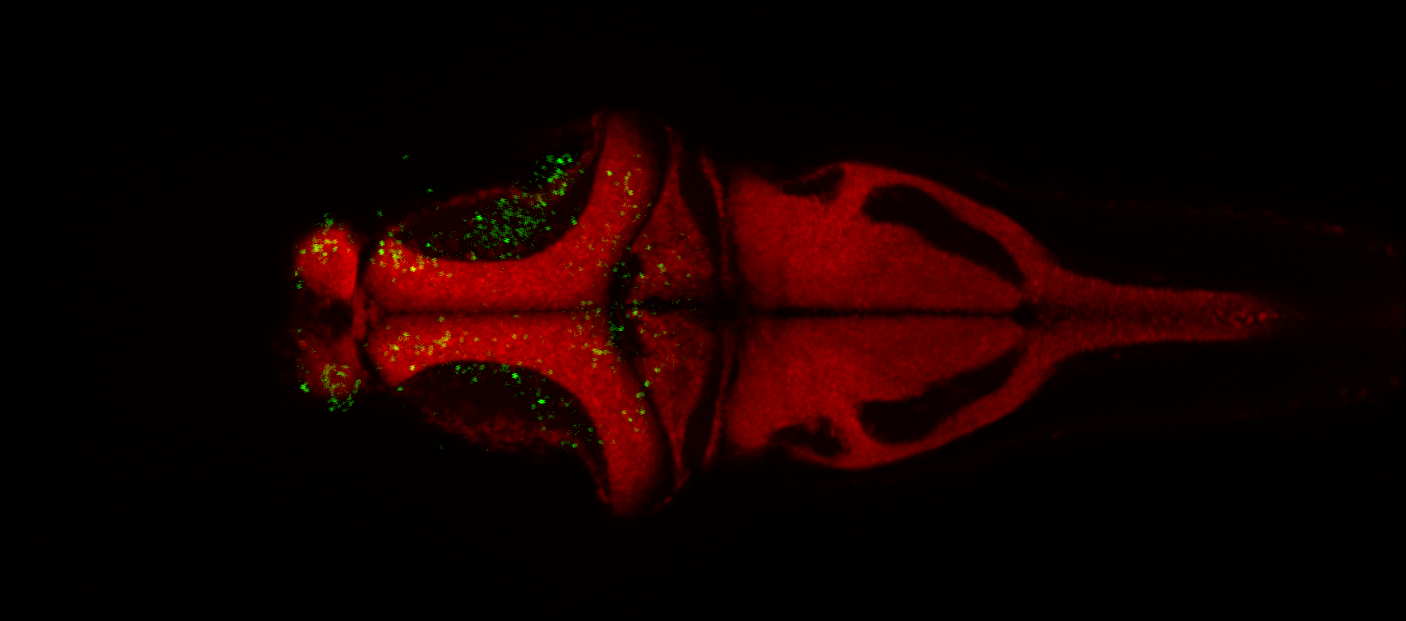

In [355]:
init_y_translation = -(size(h2b_zbrain,2) - size(zseries,2)/y_scaling) / 2 - 30
init_x_translation = -(size(h2b_zbrain,3) - size(zseries,3)/x_scaling) / 2.7
initial_tfm = Translation(init_y_translation, init_x_translation)
initial_affine = AffineMap([y_scaling 0.; 0. x_scaling], initial_tfm.translation)

zseries_init_registered = warp(zseries[19,:,:],
    initial_affine,
	Base.axes(h2b_zbrain[1,:,:]));
im = RGB.(h2b_zbrain[112,:,:]/maximum(h2b_zbrain))
channelview(im)[2:3,:,:] .= 0
channelview(im)[2,:,:] .= zseries_init_registered/maximum(zseries_init_registered)
# channelview(im)[2,:,:] .= zseries[20,:,:]/maximum(zseries[20,:,:])
im[:,:]

In [365]:
zseries_affine = qd_affine(zeroToOne(h2b_zbrain[96,:,:]),
	zeroToOne(zseries[20,:,:]), [50,50];
    initial_tfm=initial_affine)

Running coarse step
Initial minimum (9 evaluations): Box0.8773167729377747@[0.95, -0.05, -0.05, NaN]
Final minimum (98 evaluations): Box0.875899612903595@[0.9666666666666667, -0.05, -0.04791666666666667, 0.9997336579934383]
81 evaluations for initialization+sweeps, 17 for Quasi-Newton
Running fine step
Initial minimum (13 evaluations): Box0.8872015320250601@[2.0, 2.0, NaN, NaN, NaN, NaN]
minimum (104 evaluations): Box0.887134291188693@[2.0, 2.0, 0.9972222222222222, 0.0, 0.0, 1.0]
minimum (216 evaluations): Box0.887134291188693@[2.0, 2.0, 0.9972222222222222, 0.0, 0.0, 1.0]
Final minimum (248 evaluations): Box0.8871258679764823@[2.0, 1.875, 0.9972222222222222, 0.0, 0.0, 1.000935619730461]
191 evaluations for initialization+sweeps, 57 for Quasi-Newton


(AffineMap([1.2079968439617563 -0.0601021283777167; -0.062482595377332216 1.2539712136955676], [-160.24406067251462, -428.64275616465136]), 0.8871258679764823)

In [366]:
initial_affine

AffineMap([1.2531328320802004 0.0; 0.0 1.2531328320802004], [-190.875, -369.41629629629625])

In [367]:
zseries_affine

(AffineMap([1.2079968439617563 -0.0601021283777167; -0.062482595377332216 1.2539712136955676], [-160.24406067251462, -428.64275616465136]), 0.8871258679764823)

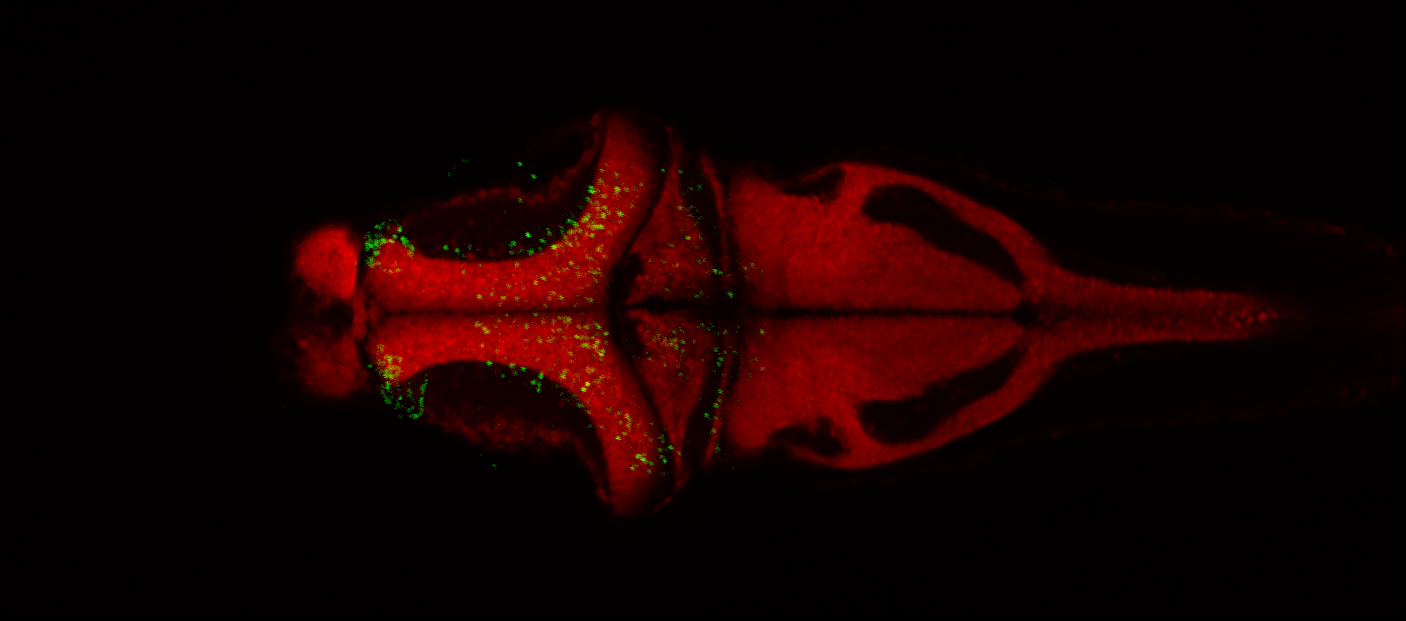

In [369]:
zseries_registered = warp(zseries[8,:,:],
    zseries_affine[1],
	Base.axes(h2b_zbrain[1,:,:]));
im = RGB.(h2b_zbrain[112,:,:]/maximum(h2b_zbrain))
channelview(im)[2:3,:,:] .= 0
channelview(im)[2,:,:] .= zseries_registered/maximum(zseries_registered)
# channelview(im)[2,:,:] .= zseries[20,:,:]/maximum(zseries[20,:,:])
im[:,:]

### Zseries 3D

In [372]:
initial_affine = AffineMap(
    [z_scaling 0. 0.; 0. y_scaling 0.; 0. 0. x_scaling],
    initial_tfm.translation)

AffineMap([0.5 0.0 0.0; 0.0 1.2531328320802004 0.0; 0.0 0.0 1.2531328320802004], [-190.875, -369.41629629629625])

In [ ]:
zseries_3d_affine = qd_affine(zeroToOne(h2b_zbrain[96,:,:]),
	zeroToOne(zseries[20,:,:]), [50,50];
    initial_tfm=initial_affine)

In [375]:
B = zeros(2,4,4,3);
A = permutedims(reshape(collect(1:48),3,4,4),[3,2,1]);
B[2,:,:,:] .= A;
B[2,1,1,:]

3-element Array{Float64,1}:
 1.0
 2.0
 3.0